In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from regions import CircleSkyRegion
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    PointSpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker, FoVBackgroundMaker
from gammapy.modeling import Fit
from gammapy.maps import Map
from scipy.stats import norm
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

In [3]:
import scipy.stats as stats
import math
import statistics
import os

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 1.0 * u.hr
l = 0
coord = SkyCoord(141.409467, 40.566962, unit="deg", frame="icrs")
pointing = coord.galactic

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(coord.galactic.l.deg, coord.galactic.b.deg),
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu")

In [8]:
# Define sky model to used simulate the data.
# Here we use a Point spatial model and a Exponential Cut Power Law spectral model.
spatial_model = PointSpatialModel(
    lon_0=coord.galactic.l, lat_0=coord.galactic.b, frame="galactic"
)
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.495, amplitude="2.72e-13 cm-2 s-1 TeV-1", reference="1 TeV", lambda_=l * u.Unit("TeV-1"), alpha = 1
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.495              
    amplitude               :   2.72e-13  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.000  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   : 181.512  deg         
    lat_0                   :  45.879  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [9]:
spatial_model_1 = PointSpatialModel(
    lon_0=coord.galactic.l, lat_0=coord.galactic.b, frame="galactic"
)
spectral_model_1 = ExpCutoffPowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", lambda_=0 * u.Unit("TeV-1"), alpha = 1
)
model_simu_1 = SkyModel(
    spatial_model=spatial_model_1,
    spectral_model=spectral_model_1,
    name="model-simu",
)

bkg_model_1 = FoVBackgroundModel(dataset_name="dataset-simu")

models_1 = Models([model_simu_1, bkg_model_1])
print(models_1)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   3.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.000  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   : 181.512  deg         
    lat_0                   :  45.879  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [10]:
def FoV(energy_reco, energy_true, livetime, irfs, pointing, geom, models, models_1,rand):
    model = models.copy()
    model_1 = models_1.copy()
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = model
    dataset.fake(rand)
    
    dataset1 = dataset.copy()
    dataset1.models = bkg_model
    
    dataset2 = dataset.copy()
    dataset2.models = bkg_model
    
    estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
    lima_maps = estimator.run(dataset1)
    significance_map = lima_maps["sqrt_ts"]
    excess_map = lima_maps["excess"]
    
    geom_image = geom.to_image().to_cube([energy_reco.squash()])
    regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
    exclusion_mask = Map.from_geom(geom_image)
    exclusion_mask.data = geom_image.region_mask([regions], inside=False)
    maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)
    
    ## original code
    dataset1 = dataset1.to_spectrum_dataset(on_region=regions)
    dataset2 = dataset2.to_spectrum_dataset(on_region=regions)
    dataset1 = maker_fov.run(dataset1)
    dataset2 = maker_fov.run(dataset2)
    
    TS0 = dataset1.stat_sum()
    models_fit = model_1[0].copy()
    models_fit_1 = model_1[0].copy()
    dataset1.models = models_fit
    dataset2.models = models_fit_1
    
    dataset1.models.parameters['lambda_'].frozen = True
    fit = Fit([dataset1])
    result_1 = fit.run()
    print(result_1)
    TS1 = result_1.total_stat
    del_TS = TS0 - TS1
    
    dataset2.models.parameters['lambda_'].frozen = False
    fit = Fit([dataset2])
    result_2 = fit.run()
    print(result_2)
    TS2 = result_2.total_stat
    del_TS_1 = TS1 - TS2
    del_TS_2 = TS0 - TS2
    
    return del_TS, dataset2, models_fit_1, del_TS_1, del_TS_2, significance_map, excess_map, dataset1, models_fit, result_1, result_2

In [11]:
def excess_maps(significance_map, excess_map):
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
    ax2 = plt.subplot(222, projection=excess_map.geom.wcs)
    
    ax1.set_title("Significance map")
    significance_map.plot(ax=ax1, add_cbar=True)

    ax2.set_title("Excess map")
    excess_map.plot(ax=ax2, add_cbar=True)
    return

In [12]:
x = [5.0,10.0,25.0,50.0,100.0] * u.hr
y1 = []

In [13]:
%%time
for i in range(len(x)):
    for j in range(100):
        y1.append(FoV(energy_reco, energy_true, x[i], irfs, pointing, geom, models, models_1,j))

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 105
	total stat : -22673.53

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 163
	total stat : -22674.46

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 94
	total stat : -24484.55

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 158
	total stat : -24484.70

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 96
	total stat : -23906.60

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       :

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 95
	total stat : -24389.75

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 150
	total stat : -24391.40

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 99
	total stat : -23795.25

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 142
	total stat : -23795.76

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 105
	total stat : -24611.15

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       :

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 96
	total stat : -23896.15

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 165
	total stat : -23896.16

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 85
	total stat : -24954.04

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 148
	total stat : -24954.38

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -23896.06

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       :

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : -24132.24

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 96
	total stat : -24133.02

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 87
	total stat : -23217.55

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 178
	total stat : -23218.07

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 86
	total stat : -24859.18

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 97
	total stat : -23069.38

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 194
	total stat : -23070.50

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 85
	total stat : -24536.99

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 142
	total stat : -24537.01

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 86
	total stat : -25054.24

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 97
	total stat : -55594.31

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 149
	total stat : -55595.85

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 95
	total stat : -55712.94

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 165
	total stat : -55714.66

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 109
	total stat : -53151.44

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       :

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 100
	total stat : -55105.56

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 150
	total stat : -55105.78

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 95
	total stat : -55817.33

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 158
	total stat : -55819.87

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : -54161.79

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       :

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 94
	total stat : -55325.47

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 161
	total stat : -55325.81

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 106
	total stat : -54503.12

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 162
	total stat : -54505.62

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 89
	total stat : -54695.33

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       :

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 100
	total stat : -53991.15

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 158
	total stat : -53991.54

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 112
	total stat : -52466.94

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 175
	total stat : -52466.99

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 106
	total stat : -54396.57

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev      

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 109
	total stat : -157564.69

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 187
	total stat : -157564.70

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 100
	total stat : -159015.38

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 150
	total stat : -159017.67

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : -158417.20

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev  

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : -159789.99

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 163
	total stat : -159790.11

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 99
	total stat : -157433.10

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 166
	total stat : -157433.50

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 99
	total stat : -158721.98

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev    

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 106
	total stat : -160841.97

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 190
	total stat : -160846.96

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 108
	total stat : -158222.44

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 162
	total stat : -158222.59

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 89
	total stat : -159545.84

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev  

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 100
	total stat : -158703.58

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 165
	total stat : -158709.01

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : -159744.03

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 163
	total stat : -159745.64

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 109
	total stat : -156685.35

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev  

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -348952.40

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 168
	total stat : -348953.50

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : -350527.70

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 168
	total stat : -350531.38

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 110
	total stat : -344367.24

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev  

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 102
	total stat : -345310.08

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 189
	total stat : -345310.09

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 111
	total stat : -346724.13

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 168
	total stat : -346724.42

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 110
	total stat : -348890.22

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev 

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 102
	total stat : -351903.49

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 167
	total stat : -351903.52

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 112
	total stat : -345132.77

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 142
	total stat : -345133.68

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -348588.16

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev 

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 102
	total stat : -351163.09

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 169
	total stat : -351163.15

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 111
	total stat : -341950.24

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 170
	total stat : -341956.32

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 109
	total stat : -347488.09

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev 

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 111
	total stat : -754477.67

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 154
	total stat : -754479.03

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -758935.00

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 169
	total stat : -758935.49

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -755979.21

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev 

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 109
	total stat : -758195.00

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 167
	total stat : -758195.14

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -758585.37

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 206
	total stat : -758585.48

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 102
	total stat : -757468.16

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev 

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -756451.13

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 170
	total stat : -756455.69

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 91
	total stat : -761817.16

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 175
	total stat : -761817.52

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 110
	total stat : -753728.52

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev  

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -765086.11

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 179
	total stat : -765086.22

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 91
	total stat : -760120.11

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 163
	total stat : -760120.13

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : -754412.48

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev  

In [14]:
del_TS_ = []
del_TS_1 = []
del_TS_2 = []
dataset_ = []
model_ = []
significance_ = []
excess_ = []
dataset_1 = []
model_1 = []
result_1 = []
result_2 = []
for i in range(len(x)):
    for j in range(100):
        del_TS_.append(y1[100*i+j][0])
        dataset_.append(y1[100*i+j][1])
        model_.append(y1[100*i+j][2])
        del_TS_1.append(y1[100*i+j][3])
        del_TS_2.append(y1[100*i+j][4])
        significance_.append(y1[100*i+j][5])
        excess_.append(y1[100*i+j][6])
        dataset_1.append(y1[100*i+j][7])
        model_1.append(y1[100*i+j][8])
        result_1.append(y1[100*i+j][9])
        result_2.append(y1[100*i+j][10])
        
index_ = []
amplitude_ = []
for k in range(500):
    index_.append(model_[k].spectral_model.index.value)
    amplitude_.append(model_[k].spectral_model.amplitude.value)

index: 2.498981439919743 += 0.25575787616982865


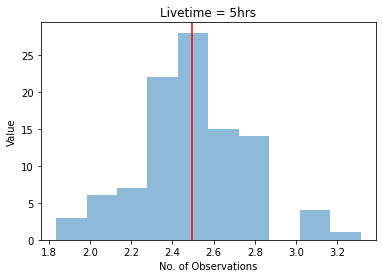

In [15]:
index = np.array(index_[0:100])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.title("Livetime = 5hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {index.mean()} += {index.std()}")

index: 2.474368517448902 += 0.14601589630637868


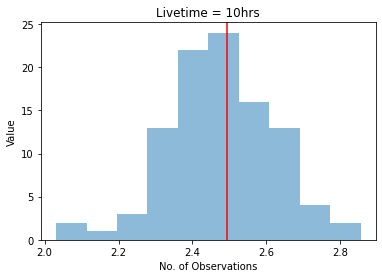

In [16]:
index = np.array(index_[100:200])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.title("Livetime = 10hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {index.mean()} += {index.std()}")

index: 2.477150073195994 += 0.10944565022709957


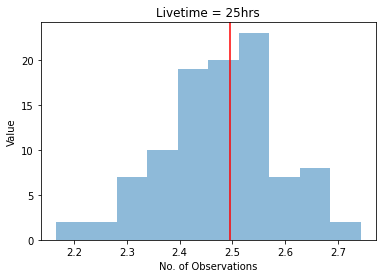

In [17]:
index = np.array(index_[200:300])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.title("Livetime = 25hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {index.mean()} += {index.std()}")

index: 2.468040678306953 += 0.06710547434222576


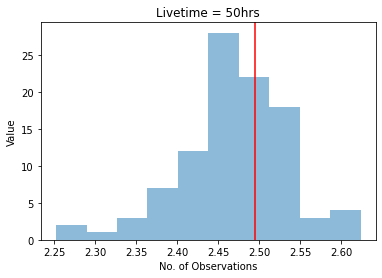

In [18]:
index = np.array(index_[300:400])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.title("Livetime = 50hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {index.mean()} += {index.std()}")

index: 2.47983730814317 += 0.04620025960987286


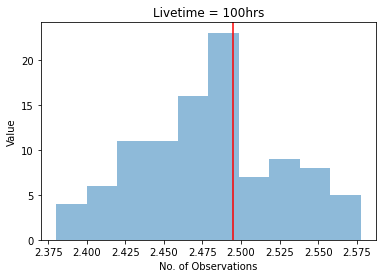

In [19]:
index = np.array(index_[400:500])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.title("Livetime = 100hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {index.mean()} += {index.std()}")

index: 2.708260504145036e-13 += 8.888052796637955e-14


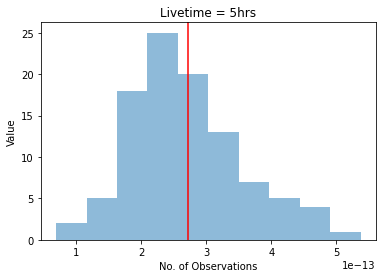

In [20]:
amplitude = np.array(amplitude_[0:100])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.title("Livetime = 5hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {amplitude.mean()} += {amplitude.std()}")

index: 2.7549257677890133e-13 += 6.154464325738952e-14


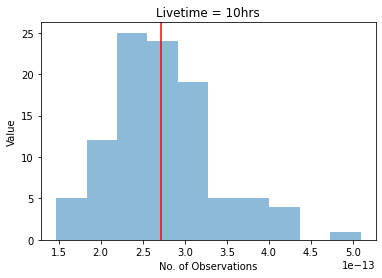

In [21]:
amplitude = np.array(amplitude_[100:200])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.title("Livetime = 10hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {amplitude.mean()} += {amplitude.std()}")

index: 2.8126097957502254e-13 += 4.5010417187158243e-14


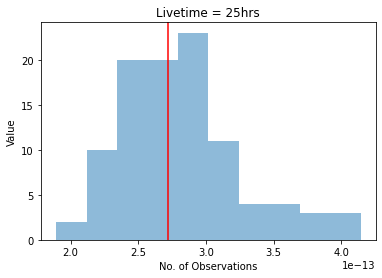

In [22]:
amplitude = np.array(amplitude_[200:300])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.title("Livetime = 25hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {amplitude.mean()} += {amplitude.std()}")

index: 2.786350776888717e-13 += 2.5837378489900976e-14


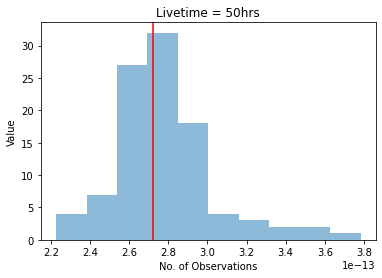

In [23]:
amplitude = np.array(amplitude_[300:400])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.title("Livetime = 50hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {amplitude.mean()} += {amplitude.std()}")

index: 2.740960707475729e-13 += 1.7573062825226458e-14


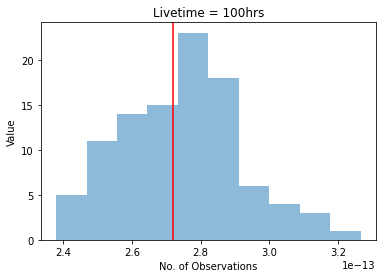

In [24]:
amplitude = np.array(amplitude_[400:500])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.title("Livetime = 100hrs")
plt.ylabel("Value")
plt.xlabel("No. of Observations")
print(f"index: {amplitude.mean()} += {amplitude.std()}")

In [25]:
print(np.average(del_TS_1[0:100]))
print(np.average(del_TS_1[100:200]))
print(np.average(del_TS_1[200:300]))
print(np.average(del_TS_1[300:400]))
print(np.average(del_TS_1[400:500]))

0.9411243132886739
0.8585991050833399
1.2088804930838524
0.8810223544569453
0.9492983272345736


Text(0.5, 1.0, 'Livetime = 5hrs')

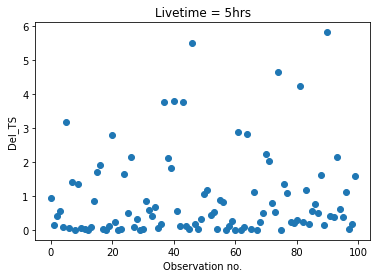

In [26]:
plt.scatter(np.linspace(0,99,100),del_TS_1[0:100])
#plt.xscale("log")
#plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("Observation no.")
plt.title("Livetime = 5hrs")

Text(0.5, 1.0, 'Livetime = 10hrs')

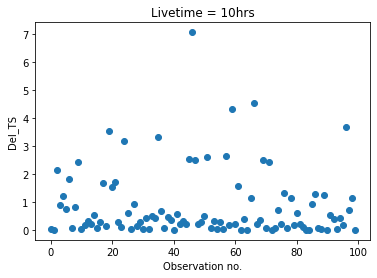

In [27]:
plt.scatter(np.linspace(0,99,100),del_TS_1[100:200])
#plt.xscale("log")
#plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("Observation no.")
plt.title("Livetime = 10hrs")

Text(0.5, 1.0, 'Livetime = 25hrs')

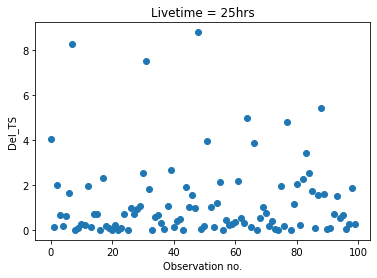

In [28]:
plt.scatter(np.linspace(0,99,100),del_TS_1[200:300])
#plt.xscale("log")
#plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("Observation no.")
plt.title("Livetime = 25hrs")

Text(0.5, 1.0, 'Livetime = 50hrs')

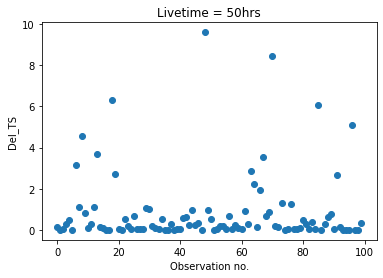

In [29]:
plt.scatter(np.linspace(0,99,100),del_TS_1[300:400])
#plt.xscale("log")
#plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("Observation no.")
plt.title("Livetime = 50hrs")

Text(0.5, 1.0, 'Livetime = 100hrs')

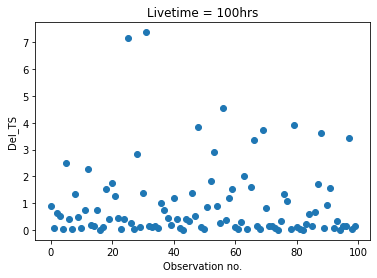

In [30]:
plt.scatter(np.linspace(0,99,100),del_TS_1[400:500])
#plt.xscale("log")
#plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("Observation no.")
plt.title("Livetime = 100hrs")

In [31]:
True_rate = []
for j in range(len(x)):
    r=0
    for i in range(100):
        if result_1[(100*j)+i].success==1:
            r = r+1
    True_rate.append(r)
print(f"True success rate for fixed parameter lambda for different livetime: {True_rate}")

True success rate for fixed parameter lambda for different livetime: [100, 100, 100, 100, 100]


In [32]:
True_rate = []
for j in range(len(x)):
    r=0
    for i in range(100):
        if result_2[(100*j)+i].success==1:
            r = r+1
    True_rate.append(r)
print(f"True success rate for free parameter lambda for different livetime: {True_rate}")

True success rate for free parameter lambda for different livetime: [100, 100, 100, 100, 100]


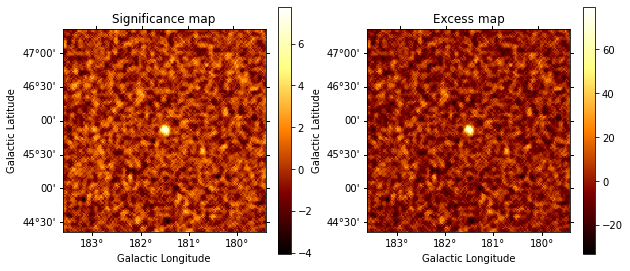

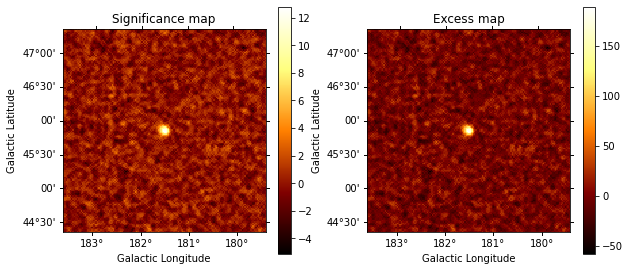

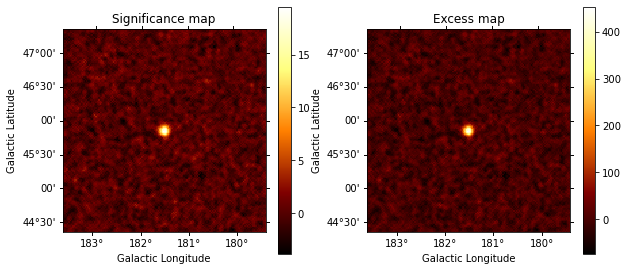

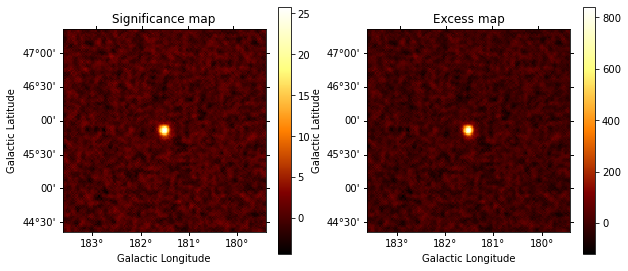

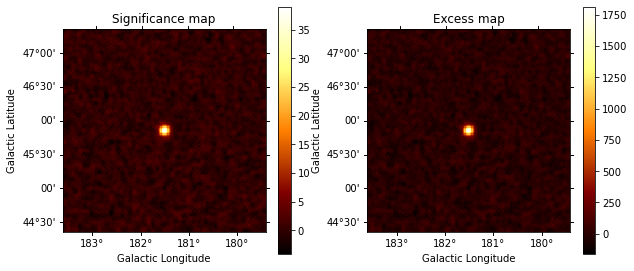

In [33]:
excess_maps(significance_[0], excess_[0])
excess_maps(significance_[100], excess_[100])
excess_maps(significance_[200], excess_[200])
excess_maps(significance_[300], excess_[300])
excess_maps(significance_[400], excess_[400])

In [34]:
True_rate = []
for j in range(len(x)):
    r=0
    for i in range(100):
        if result_2[(100*j)+i].success==1 and result_1[(100*j)+i].success==1:
            r = r+1
    True_rate.append(r)
print(f"True success rate different livetime: {True_rate}")

True success rate different livetime: [100, 100, 100, 100, 100]
